# Install and Import

In [ ]:
! pip install geopandas
! pip install folium

     |████████████████████████████████| 972kB 4.4MB/s 
     |████████████████████████████████| 10.9MB 12.0MB/s 
     |████████████████████████████████| 14.8MB 308kB/s 


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
import math
from collections import namedtuple

import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib.ticker as mtick
from random import sample 
import datetime
from pandas.plotting import register_matplotlib_converters

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster, TimestampedGeoJson

import datetime
import os

In [ ]:
register_matplotlib_converters()

# Section #1

## Get data

In [ ]:
global_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
global_death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
global_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [ ]:
global_confirmed.head() 

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,38398,38494,38520,38544,38572,38606,38641,38716,38772,38815,38855,38872,38883,38919,39044,39074,39096,39145,39170,39186,39192,39227,39233,39254,39268,39285,39290,39297,39341,39422,39486,39548,39616,39693,39703,39799,39870,39928,39994,40026
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10255,10406,10553,10704,10860,11021,11185,11353,11520,11672,11816,11948,12073,12226,12385,12535,12666,12787,12921,13045,13153,13259,13391,13518,13649,13806,13965,14117,14266,14410,14568,14730,14899,15066,15231,15399,15570,15752,15955,16212
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,46364,46653,46938,47216,47488,47752,48007,48254,48496,48734,48966,49194,49413,49623,49826,50023,50214,50400,50579,50754,50914,51067,51213,51368,51530,51690,51847,51995,52136,52270,52399,52520,52658,52804,52940,53072,53325,53399,53584,53777
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1215,1261,1261,1301,1301,1344,1344,1344,1438,1438,1483,1483,1564,1564,1564,1681,1681,1753,1753,1836,1836,1836,1966,1966,2050,2050,2110,2110,2110,2370,2370,2568,2568,2696,2696,2696,2995,2995,3190,3190
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2965,2981,3033,3092,3217,3279,3335,3388,3439,3569,3675,3789,3848,3901,3991,4117,4236,4363,4475,4590,4672,4718,4797,4905,4972,5114,5211,5370,5402,5530,5725,5725,5958,6031,6246,6366,6488,6680,6846,7096


In [ ]:
print(global_confirmed.shape, global_death.shape, global_recovered.shape)

(267, 272) (267, 272) (254, 272)


In [ ]:
global_confirmed['Country/Region'].value_counts()

China                       33
Canada                      14
United Kingdom              11
France                      11
Australia                    8
                            ..
Angola                       1
Greece                       1
South Sudan                  1
El Salvador                  1
Central African Republic     1
Name: Country/Region, Length: 189, dtype: int64

In [ ]:
date = '10/15/20'

In [ ]:
global_confirmed_now = global_confirmed[['Province/State', 'Country/Region', 'Lat', 'Long', date]]
global_death_now = global_death[['Province/State', 'Country/Region', 'Lat', 'Long', date]]
global_recovered_now = global_recovered[['Province/State', 'Country/Region', 'Lat', 'Long', date]]

In [ ]:
global_confirmed_now.head()

,Province/State,Country/Region,Lat,Long,10/15/20
0,NaN,Afghanistan,33.93911,67.709953,40026
1,NaN,Albania,41.15330,20.168300,16212
2,NaN,Algeria,28.03390,1.659600,53777
3,NaN,Andorra,42.50630,1.521800,3190
4,NaN,Angola,-11.20270,17.873900,7096


In [ ]:
global_confirmed_now.rename(columns={date:'Confirmed'}, inplace=True)
global_death_now.rename(columns={date:'Death'}, inplace=True)
global_recovered_now.rename(columns={date:'Recovered'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
global_now = pd.merge(global_confirmed_now,global_death_now,on=['Province/State', 'Country/Region', 'Lat', 'Long'])
global_now = pd.merge(global_now,global_recovered_now,on=['Province/State', 'Country/Region', 'Lat', 'Long'])

In [ ]:
global_now

,Province/State,Country/Region,Lat,Long,Confirmed,Death,Recovered
0,NaN,Afghanistan,33.939110,67.709953,40026,1481,33447
1,NaN,Albania,41.153300,20.168300,16212,439,9864
2,NaN,Algeria,28.033900,1.659600,53777,1827,37603
3,NaN,Andorra,42.506300,1.521800,3190,59,2011
4,NaN,Angola,-11.202700,17.873900,7096,228,2928
...,...,...,...,...,...,...,...
213,NaN,Venezuela,6.423800,-66.589700,85469,720,77689
214,NaN,West Bank and Gaza,31.952200,35.233200,46100,401,39585
215,NaN,Western Sahara,24.215500,-12.885800,10,1,8
216,NaN,Zambia,-13.133897,27.849332,15659,346,14899


In [ ]:
us_confirmed_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
us_confirmed = us_confirmed_raw.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key', 'Lat', 'Long_'])
us_confirmed.rename(columns={'Province_State':'Province/State'}, inplace=True)
us_confirmed = us_confirmed.groupby(by='Province/State').sum().reset_index()
us_confirmed['Country/Region'] = 'US'

In [ ]:
us_death_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
us_death = us_death_raw.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key', 'Lat', 'Long_'])
us_death.rename(columns={'Province_State':'Province/State'}, inplace=True)
us_death = us_death.groupby(by='Province/State').sum().reset_index()
us_death['Country/Region'] = 'US'

In [ ]:
us_lat_long = pd.read_csv(
    'https://raw.githubusercontent.com/RedShuuu/Mix/master/data/US_states_lat_long.csv').drop(
        'State', axis=1).rename(
            columns={'City': 'Province/State', 'Latitude': 'Lat', 'Longitude': 'Long'})
us_lat_long.head()

,Lat,Long,Province/State
0,32.601011,-86.680736,Alabama
1,61.302501,-158.775020,Alaska
2,34.168219,-111.930907,Arizona
3,34.751928,-92.131378,Arkansas
4,37.271875,-119.270415,California


In [ ]:
us_confirmed = pd.merge(us_confirmed, us_lat_long, on='Province/State')
us_death = pd.merge(us_death, us_lat_long, on='Province/State')

In [ ]:
global_now_no_us = global_now.drop(index=global_now[global_now['Country/Region'] == 'US'].index)
global_now_no_us.reset_index(inplace=True)
global_now_no_us.drop(columns='index', inplace=True)

In [ ]:
us_confirmed_data_now = us_confirmed[['Province/State', 'Country/Region', 'Lat', 'Long', date]]
us_confirmed_data_now.rename(columns={date:'Confirmed'}, inplace=True)
us_death_data_now = us_death[['Province/State', 'Country/Region', 'Lat', 'Long', date]]
us_death_data_now.rename(columns={date:'Death'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
us_now = pd.merge(us_confirmed_data_now, us_death_data_now, on=['Province/State', 'Country/Region', 'Lat', 'Long'])

## Plot

In [ ]:
us_confirmed_series = global_confirmed[global_confirmed['Country/Region']=='US'].reset_index().drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long', 'index'])
us_death_series = global_death[global_death['Country/Region']=='US'].reset_index().drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long', 'index'])
us_recovered_series = global_recovered[global_recovered['Country/Region']=='US'].reset_index().drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long', 'index'])

In [ ]:
us_confirmed_series = us_confirmed_series.T.rename(columns={0: 'Confirmed'})
us_confirmed_series.index = pd.to_datetime(us_confirmed_series.index)
us_death_series = us_death_series.T.rename(columns={0: 'Death'})
us_death_series.index = pd.to_datetime(us_death_series.index)
us_recovered_series = us_recovered_series.T.rename(columns={0: 'Recovered'})
us_recovered_series.index = pd.to_datetime(us_recovered_series.index)

In [ ]:
us_confirmed_series

,Confirmed
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
...,...
2020-10-11,7762546
2020-10-12,7804199
2020-10-13,7856605
2020-10-14,7916099


Populating the interactive namespace from numpy and matplotlib


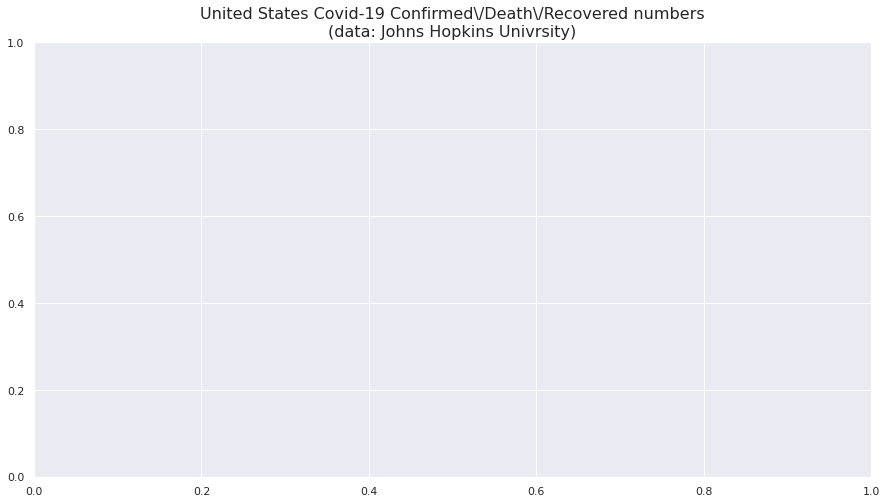

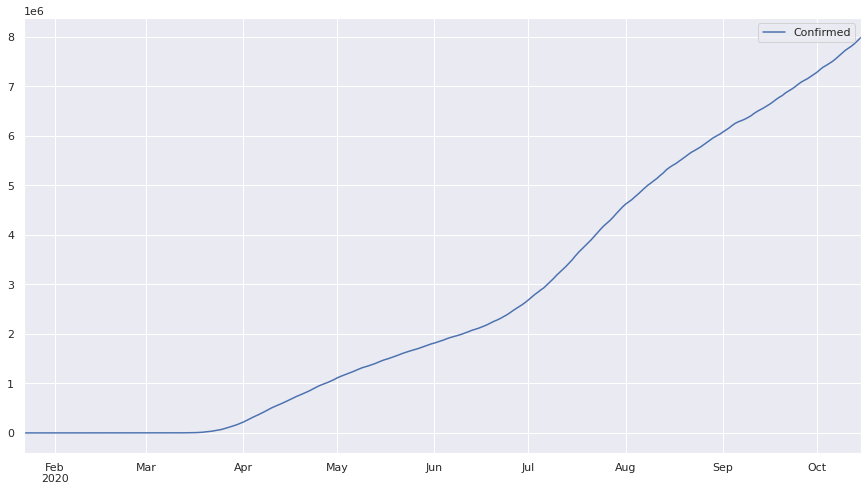

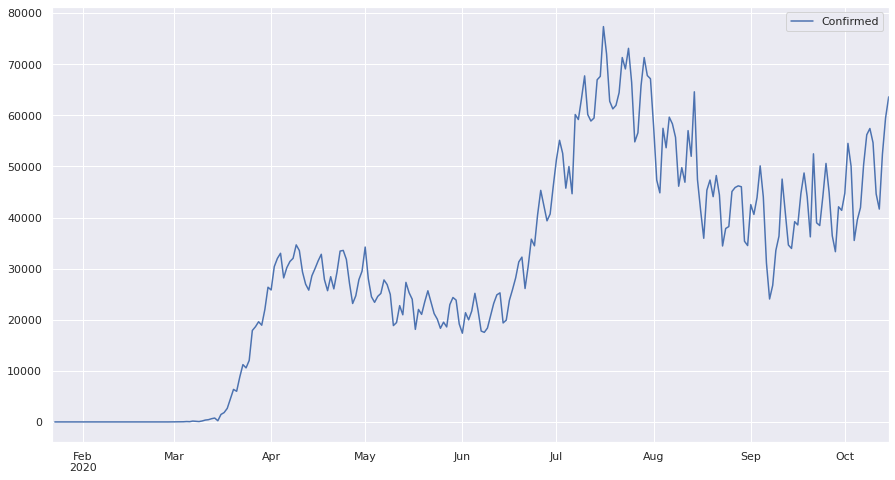

In [ ]:
%matplotlib inline 
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 8)   # set image size

plt.title('United States Covid-19 Confirmed\/Death\/Recovered\n(data: Johns Hopkins Univrsity)', fontsize=16)
sns.set(color_codes=True)
us_confirmed_series.plot()
us_confirmed_series.diff().plot()

In [ ]:
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

## Create map

In [ ]:
map_now = folium.Map(location=[30, 0], 
                 tiles = "CartoDB dark_matter",
                 detect_retina = True,
                 zoom_start=2,
                 no_touch=True)

In [ ]:
world_countries_geo = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"

folium.Choropleth(
    geo_data=world_countries_geo,
    name='choropleth',
#     data=filtered_data_last,
#     columns=['Province/State', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='green',
    fill_opacity=0.18,
    line_opacity=0.7
).add_to(map_now)

In [ ]:
for i in range(len(global_now_no_us)):
  lat = global_now_no_us.loc[i, 'Lat']
  lon = global_now_no_us.loc[i, 'Long']
  country = global_now_no_us.loc[i, 'Country/Region']
  province = global_now_no_us.loc[i, 'Province/State']
  if str(province) == 'nan':
    province=''
  recovered = global_now_no_us.loc[i, 'Recovered']
  death = global_now_no_us.loc[i, 'Death']
  confirmed = global_now_no_us.loc[i, 'Confirmed']

  if confirmed == 0 :
    _radius_rec = 0
  else:
    _radius_rec = math.pow(confirmed,1/3)

  _popup_rec = str(country) + ' ' + str(province) + '(Confirmed='+str(confirmed) + ' Deaths=' + str(death) + ' Recovered=' + str(recovered) + ')'

  _color_rec = '#81D8D0'

  folium.CircleMarker(location = [lat,lon], 
                        radius = _radius_rec, 
                        popup = _popup_rec, 
                        color = _color_rec, 
                        fill_opacity = 0.1,
                      weight = 2, 
                      fill = True, 
                      fillColor = _color_rec).add_to(map_now) 

In [ ]:
for i in range(len(us_now)):
  lat = us_now.loc[i, 'Lat']
  lon = us_now.loc[i, 'Long']
  country = us_now.loc[i, 'Country/Region']
  province = us_now.loc[i, 'Province/State']
  death = us_now.loc[i, 'Death']
  confirmed = us_now.loc[i, 'Confirmed']

  if confirmed == 0 :
    _radius_rec = 0
  else:
    _radius_rec = math.pow(confirmed,1/3)

  _popup_rec = str(country) + ' ' + str(province) + '(Confirmed='+str(confirmed) + ' Deaths=' + str(death) + ')'

  _color_rec = '#81D8D0'

  folium.CircleMarker(location = [lat,lon], 
                        radius = _radius_rec, 
                        popup = _popup_rec, 
                        color = _color_rec, 
                        fill_opacity = 0.1,
                      weight = 2, 
                      fill = True, 
                      fillColor = _color_rec).add_to(map_now) 

In [ ]:
map_now

In [ ]:
# map_now.save('confirmed_1013.html')

# Section #2

In [ ]:
today_date = '10-13-2020'
daily_report_data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/' + today_date + '.csv'

In [ ]:
daily_report_raw_data = pd.read_csv(daily_report_data_url)

In [ ]:
daily_report_raw_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2020-10-14 04:24:05,33.93911,67.709953,39928,1480,33308,5140.0,Afghanistan,102.567947,3.706672
1,NaN,NaN,NaN,Albania,2020-10-14 04:24:05,41.15330,20.168300,15752,429,9675,5648.0,Albania,547.362569,2.723464
2,NaN,NaN,NaN,Algeria,2020-10-14 04:24:05,28.03390,1.659600,53399,1818,37492,14089.0,Algeria,121.773614,3.404558
3,NaN,NaN,NaN,Andorra,2020-10-14 04:24:05,42.50630,1.521800,2995,57,1928,1010.0,Andorra,3876.269980,1.903172
4,NaN,NaN,NaN,Angola,2020-10-14 04:24:05,-11.20270,17.873900,6680,222,2761,3697.0,Angola,20.324790,3.323353


In [ ]:
daily_report_raw_data[daily_report_raw_data['Province_State'] == 'New Jersey']

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
2445,34001.0,Atlantic,New Jersey,US,2020-10-14 04:24:05,39.475387,-74.658485,4517,261,0,4256.0,"Atlantic, New Jersey, US",1713.126256,5.778171
2446,34003.0,Bergen,New Jersey,US,2020-10-14 04:24:05,40.960109,-74.071643,23323,2052,0,21271.0,"Bergen, New Jersey, US",2501.925548,8.798182
2447,34005.0,Burlington,New Jersey,US,2020-10-14 04:24:05,39.876811,-74.669278,7598,504,0,7094.0,"Burlington, New Jersey, US",1706.077705,6.633325
2448,34007.0,Camden,New Jersey,US,2020-10-14 04:24:05,39.803438,-74.963888,10553,615,0,9938.0,"Camden, New Jersey, US",2083.633614,5.827727
2449,34009.0,Cape May,New Jersey,US,2020-10-14 04:24:05,39.150088,-74.801702,1060,99,0,961.0,"Cape May, New Jersey, US",1151.685698,9.339623
2450,34011.0,Cumberland,New Jersey,US,2020-10-14 04:24:05,39.371994,-75.107126,3879,160,0,3719.0,"Cumberland, New Jersey, US",2594.180315,4.124774
2451,34013.0,Essex,New Jersey,US,2020-10-14 04:24:05,40.786813,-74.246580,21913,2131,0,19782.0,"Essex, New Jersey, US",2742.639006,9.724821
2452,34015.0,Gloucester,New Jersey,US,2020-10-14 04:24:05,39.715811,-75.139955,5008,234,0,4774.0,"Gloucester, New Jersey, US",1717.209124,4.672524
2453,34017.0,Hudson,New Jersey,US,2020-10-14 04:24:05,40.737662,-74.075157,21286,1519,0,19767.0,"Hudson, New Jersey, US",3165.717566,7.136146
2454,34019.0,Hunterdon,New Jersey,US,2020-10-14 04:24:05,40.563352,-74.912842,1461,126,0,1335.0,"Hunterdon, New Jersey, US",1174.711146,8.624230


# Reference

[2019-nCoV疫情传播可视化和预测--交互式地图分析
](https://www.kesci.com/home/project/5e44d8d15f2816002cec62a0)

[Visualizing Bike Mobility in London using Interactive Maps and Animations](https://towardsdatascience.com/visualizing-bike-mobility-in-london-using-interactive-maps-for-absolute-beginners-3b9f55ccb59)

[Tracking the spread of 2019 Coronavirus](https://www.kaggle.com/gpreda/tracking-the-spread-of-2019-coronavirus)